In [1]:
import itertools
import seaborn as sb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib
import math

plt.style.use("dark_background")

In [4]:
data = pd.read_csv("Datasets/Air Passengers/AirPassengers.csv")

data = data.rename({"Month": "month", "#Passengers": "passengers"}, axis=1)
data["month"] = pd.to_datetime(data["month"])
data = data.set_index("month")
data = data.asfreq(freq="MS")

In [5]:
data_tr, data_te = train_test_split(data, test_size=0.2, shuffle=False)

<ipython-input-6-d8711a7a07d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tr["passengers_log"] = np.log(data_tr["passengers"])
<ipython-input-6-d8711a7a07d5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tr["passengers_log_diff"] = data_tr["passengers_log"].diff(1)


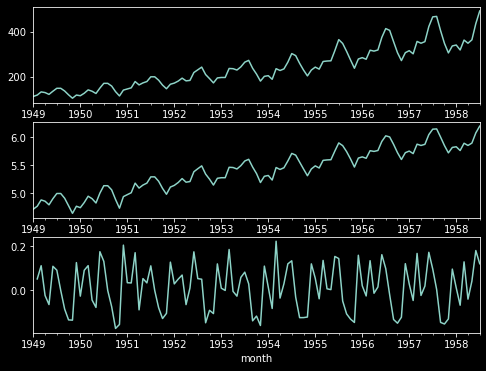

In [6]:
data_tr["passengers_log"] = np.log(data_tr["passengers"])
data_tr["passengers_log_diff"] = data_tr["passengers_log"].diff(1)

fig, axes = plt.subplots(3, 1, figsize=(8, 6))
data_tr["passengers"].plot.line(ax=axes[0]);
data_tr["passengers_log"].plot.line(ax=axes[1]);
data_tr["passengers_log_diff"].plot.line(ax=axes[2]);

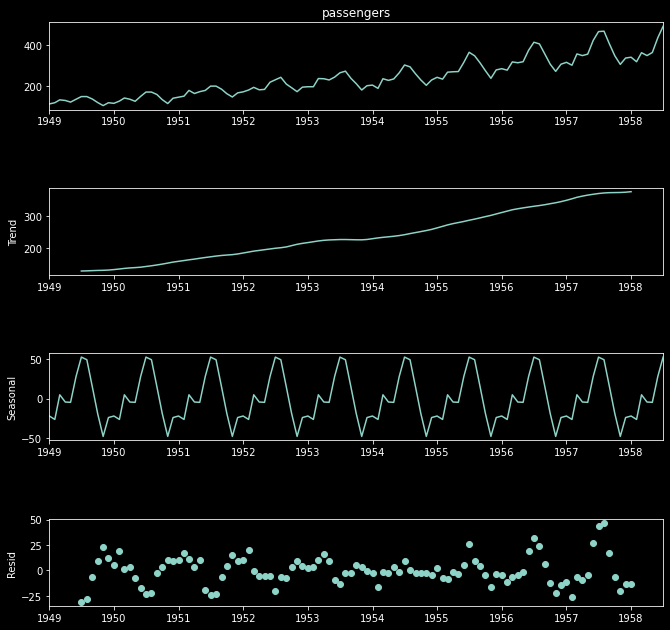

In [7]:
decomp = sm.tsa.seasonal_decompose(data_tr["passengers"], model="additive")
fig = decomp.plot()
fig.set_size_inches(10, 10)

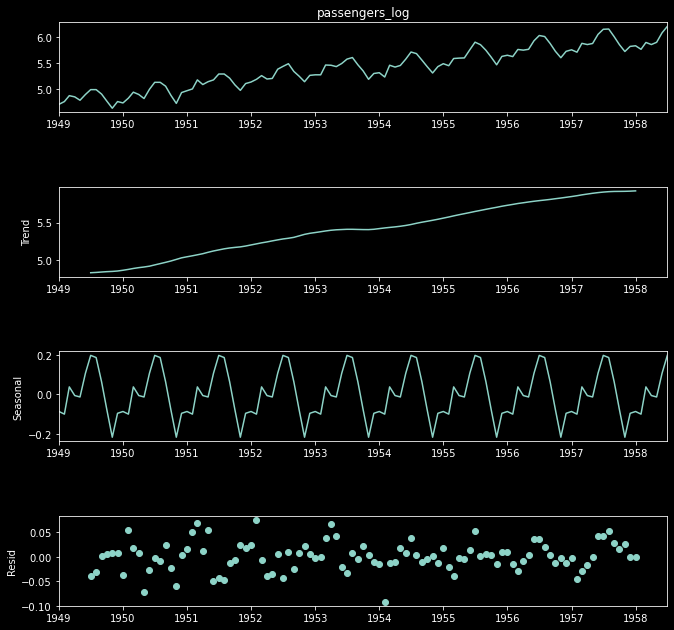

In [8]:
decomp = sm.tsa.seasonal_decompose(data_tr["passengers_log"], model="additive")
fig = decomp.plot()
fig.set_size_inches(10, 10)

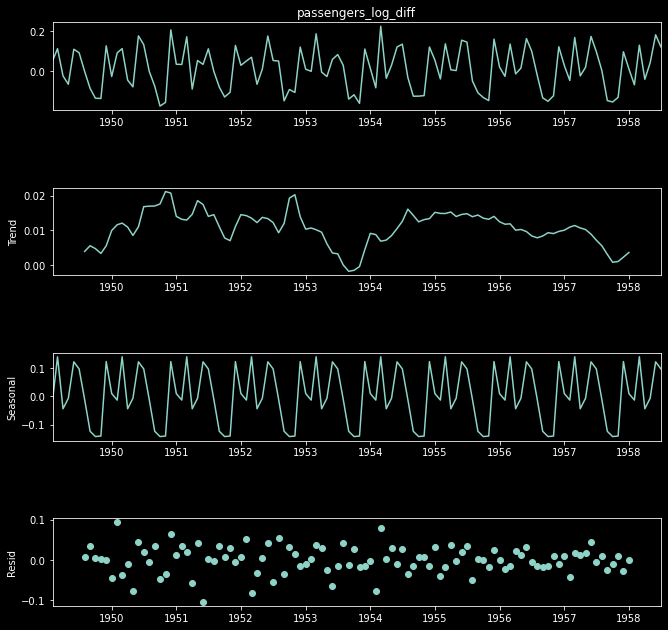

In [11]:
decomp = sm.tsa.seasonal_decompose(data_tr["passengers_log_diff"].dropna(), model="additive")
fig = decomp.plot()
fig.set_size_inches(10, 10)

C:\Users\82104\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


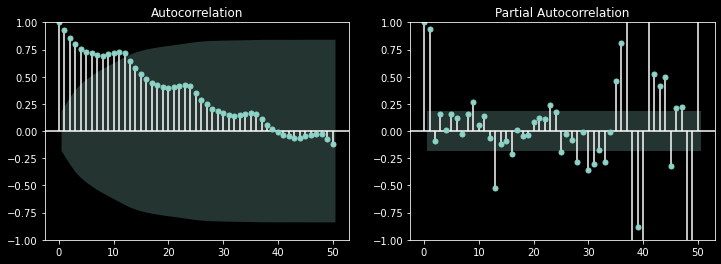

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sm.graphics.tsa.plot_acf(ax=axes[0], x=data_tr["passengers_log"], lags=50);
sm.graphics.tsa.plot_pacf(ax=axes[1], x=data_tr["passengers_log"], lags=50);

C:\Users\82104\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


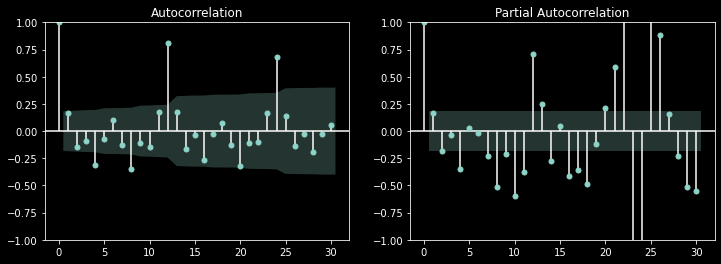

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sm.graphics.tsa.plot_acf(ax=axes[0], x=data_tr["passengers_log_diff"].dropna(), lags=30);
sm.graphics.tsa.plot_pacf(ax=axes[1], x=data_tr["passengers_log_diff"].dropna(), lags=30);

# Non-Seasonal ARIMA Modeling

## Hyperparameter Tunning

### Implementation

C:\Users\82104\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\82104\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\82104\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\82104\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\8210

best_params: (1, 1, 2)
r2_score: -0.14268534269971256


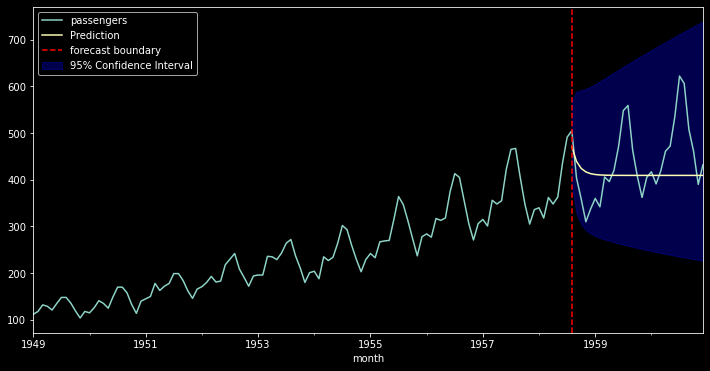

In [15]:
minim = math.inf
for params in itertools.product(range(0, 3), range(0, 2), range(0, 3)):
    model = SARIMAX(endog=data_tr["passengers_log"], order=params)
    hist = model.fit()
    aic = hist.aic
    if aic < minim:
        minim = aic
        best_params = params
print(f"best_params: {best_params}")

model = SARIMAX(data_tr["passengers_log"], order=best_params)
hist = model.fit()
hist.summary()

pred_res = hist.get_forecast(len(data_te))
preds = np.exp(pred_res.predicted_mean)
preds_lb = np.exp(pred_res.conf_int().iloc[:, 0])
preds_ub = np.exp(pred_res.conf_int().iloc[:, 1])

fig = plt.figure(figsize=(12, 6))
data["passengers"].plot.line();
preds.plot.line(label="Prediction");
plt.axvline(x="1958-08-01", linestyle="--", color="r", label="forecast boundary");
plt.fill_between(x=data_te.index, y1=preds_lb, y2=preds_ub, color="b", alpha=0.3, label="95% Confidence Interval");
plt.legend(loc="upper left");
print(f"r2_score: {r2_score(data_te['passengers'], preds)}")

# Seasonal ARIMA Modeling

C:\Users\82104\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\82104\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.order: (1, 1, 2)
model.seasonal_order: (1, 1, 2, 12)
r2_score: 0.9595670517816234


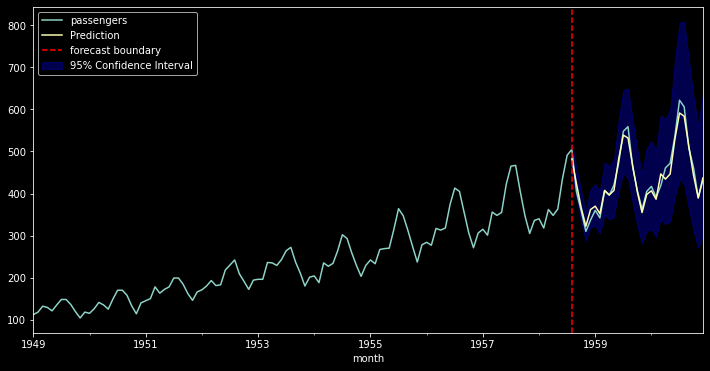

In [16]:
model = SARIMAX(data_tr["passengers_log"], order=best_params, seasonal_order=best_params + (12,))
hist = model.fit()
hist.summary()

pred_res = hist.get_forecast(len(data_te))
preds = np.exp(pred_res.predicted_mean)
preds_lb = np.exp(pred_res.conf_int().iloc[:, 0])
preds_ub = np.exp(pred_res.conf_int().iloc[:, 1])

fig = plt.figure(figsize=(12, 6))
data["passengers"].plot.line();
preds.plot.line(label="Prediction");
plt.axvline(x="1958-08-01", linestyle="--", color="r", label="forecast boundary");
plt.fill_between(x=data_te.index, y1=preds_lb, y2=preds_ub, color="b", alpha=0.3, label="95% Confidence Interval");
plt.legend(loc="upper left");

print(f"model.order: {model.order}")
print(f"model.seasonal_order: {model.seasonal_order}")
print(f"r2_score: {r2_score(data_te['passengers'], preds)}")

C:\Users\82104\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


model.order: (1, 0, 2)
model.seasonal_order: (1, 0, 2, 12)
r2_score: 0.9308086330868935


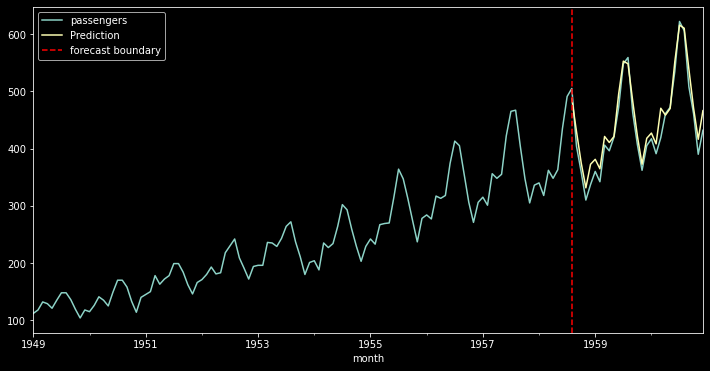

In [17]:
params = (1, 0, 2)
model = SARIMAX(data_tr["passengers_log_diff"], order=params, seasonal_order=params + (12,))
hist = model.fit()
hist.summary()

pred_res = hist.get_forecast(len(data_te))
preds = np.exp(data_tr["passengers_log"].iloc[-1] + pred_res.predicted_mean.cumsum())
# preds_lb = np.exp(data_tr["passengers_log"].iloc[-1] + pred_res.conf_int().iloc[:, 0].cumsum())
# preds_ub = np.exp(data_tr["passengers_log"].iloc[-1] + pred_res.conf_int().iloc[:, 1].cumsum())
# preds = np.exp(pred_res.predicted_mean)
# preds_lb = np.exp(pred_res.conf_int().iloc[:, 0])
# preds_ub = np.exp(pred_res.conf_int().iloc[:, 1])

fig = plt.figure(figsize=(12, 6))
data["passengers"].plot.line();
preds.plot.line(label="Prediction");
plt.axvline(x="1958-08-01", linestyle="--", color="r", label="forecast boundary");
# plt.fill_between(x=data_te.index, y1=preds_lb, y2=preds_ub, color="b", alpha=0.3, label="95% Confidence Interval");
plt.legend(loc="upper left");

print(f"model.order: {model.order}")
print(f"model.seasonal_order: {model.seasonal_order}")
print(f"r2_score: {r2_score(data_te['passengers'], preds)}")

## Hyperparameter Tunning

### Using `pmdarima.arima.auto_arima()`

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-368.055, Time=0.32 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-335.753, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-365.460, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-372.171, Time=0.30 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-345.397, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-370.441, Time=0.47 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-370.509, Time=0.71 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-366.182, Time=0.23 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-368.343, Time=0.87 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-364.570, Time=0.19 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-370.520, Time=0.48 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-370.241, Time=0.48 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-371.865, Time=0.24 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-368.579, Time=0.65 sec
 ARIMA(0,1,1)(0,1,1

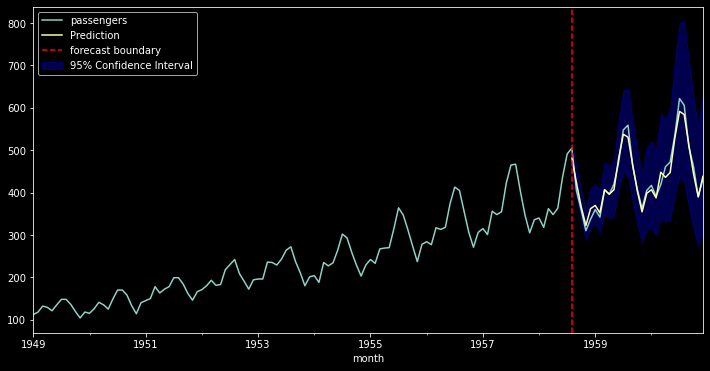

In [18]:
model = auto_arima(data_tr["passengers_log"], start_p=1, max_p=3, d=1, start_q=1, max_q=3, seasonal=True, max_P=3, D=1, max_Q=3, m=12, trace=True, error_action="ignore")

pred_res = model.predict(len(data_te), return_conf_int=True)
preds = pd.Series(np.exp(pred_res[0]), index=data_te.index)
preds_lb = pd.Series(np.exp(pred_res[1])[:, 0], index=data_te.index)
preds_ub = pd.Series(np.exp(pred_res[1])[:, 1], index=data_te.index)

# model = SARIMAX(data_tr["passengers_log"], order=model.order, seasonal_order=model.seasonal_order)
# hist = model.fit()
# hist.summary()

# pred_res = hist.get_forecast(len(data_te))
# preds = np.exp(pred_res.predicted_mean)
# preds_lb = np.exp(pred_res.conf_int().iloc[:, 0])
# preds_ub = np.exp(pred_res.conf_int().iloc[:, 1])

fig = plt.figure(figsize=(12, 6))
data["passengers"].plot.line();
preds.plot.line(label="Prediction");
plt.axvline(x="1958-08-01", linestyle="--", color="r", label="forecast boundary");
plt.fill_between(x=data_te.index, y1=preds_lb, y2=preds_ub, color="b", alpha=0.3, label="95% Confidence Interval");
plt.legend(loc="upper left");
print(f"r2_score: {r2_score(data_te['passengers'], preds)}")